## Analytical context

This case is based on a challenge proposed by Red Hat on the Kaggle platform.

Red Hat is able to obtain a significant amount of behavioral information from its customers. The interest of the company is based on the search for better methods to analyze its customers to predict on which they should make a special emphasis that could become high value customers.

This challenge aims to create a ranking algorithm that identifies customers with the greatest potential to become high-value customers for Red Hat based on their activity.

In [97]:
# Import the libraries

import pandas as pd
import numpy as np
import io

The first fact to highlight is that the information is presented anonymized.

A large number of fields of a categorical nature are appreciated.

In [98]:
# Load the dataset 

people = pd.read_csv('Datasets/people.csv', sep = ',') 
people.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,...,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,...,False,False,True,False,False,False,True,True,False,84


In [99]:
activity = pd.read_csv('Datasets/act_train.csv', sep = ',')
activity.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


You can see that there is the same key in the people_id column, so you can start thinking about some kind of cross between these data.

# <h1 id="ingenieria">Data Engineering</h1>

We will now evaluate the size of the datasets and the completeness of the information in the different available variables.

In [100]:
# Show the shape

print(people.shape)

# Show the null percent

100*people.isnull().sum()/people.shape[0]

(189118, 41)


people_id    0.0
char_1       0.0
group_1      0.0
char_2       0.0
date         0.0
char_3       0.0
char_4       0.0
char_5       0.0
char_6       0.0
char_7       0.0
char_8       0.0
char_9       0.0
char_10      0.0
char_11      0.0
char_12      0.0
char_13      0.0
char_14      0.0
char_15      0.0
char_16      0.0
char_17      0.0
char_18      0.0
char_19      0.0
char_20      0.0
char_21      0.0
char_22      0.0
char_23      0.0
char_24      0.0
char_25      0.0
char_26      0.0
char_27      0.0
char_28      0.0
char_29      0.0
char_30      0.0
char_31      0.0
char_32      0.0
char_33      0.0
char_34      0.0
char_35      0.0
char_36      0.0
char_37      0.0
char_38      0.0
dtype: float64

In [101]:
# We repet with the other dataset 

print(activity.shape)
100*activity.isnull().sum()/activity.shape[0]

# We gonna delete the columns 90% null and fill 

(2197291, 15)


people_id             0.000000
activity_id           0.000000
date                  0.000000
activity_category     0.000000
char_1               92.826849
char_2               92.826849
char_3               92.826849
char_4               92.826849
char_5               92.826849
char_6               92.826849
char_7               92.826849
char_8               92.826849
char_9               92.826849
char_10               7.173151
outcome               0.000000
dtype: float64

It is evident that the fields char_1 to char_9 have 92% of their values in null. This amount is very high to apply imputation methods, so we will choose to eliminate the columns with this problem.

In the case of the categorical variable char_10 there is a proportion of nulls (7.17 \%) that we can replace by the mode.

In [102]:
# Show the columns 

activity.columns

Index(['people_id', 'activity_id', 'date', 'activity_category', 'char_1',
       'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8',
       'char_9', 'char_10', 'outcome'],
      dtype='object')

In [103]:
# Delete columns with null values

activity.drop(columns=['char_1','char_2','char_3','char_4','char_5','char_6','char_7','char_8','char_9'],inplace=True)

print(activity.shape)

(2197291, 6)


In [104]:
activity.head() 

,people_id,activity_id,date,activity_category,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,type 1,0


In [105]:
# Fill char_10 with the mode

activity['char_10'] = activity['char_10'].fillna(activity["char_10"].mode()[0])

In [106]:
# We data is clean of null dates

100*activity.isnull().sum()/activity.shape[0]

people_id            0.0
activity_id          0.0
date                 0.0
activity_category    0.0
char_10              0.0
outcome              0.0
dtype: float64

## Preparing for the merge

It is appreciated that there are two variables that have the same names in both data sets (date and char_10) so it is good practice to rename these columns to avoid confusion when unifying the sources.

In [107]:
activity.head()

,people_id,activity_id,date,activity_category,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,type 1,0


In [108]:
print(activity.columns)
print(people.columns)

Index(['people_id', 'activity_id', 'date', 'activity_category', 'char_10',
       'outcome'],
      dtype='object')
Index(['people_id', 'char_1', 'group_1', 'char_2', 'date', 'char_3', 'char_4',
       'char_5', 'char_6', 'char_7', 'char_8', 'char_9', 'char_10', 'char_11',
       'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17',
       'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23',
       'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29',
       'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35',
       'char_36', 'char_37', 'char_38'],
      dtype='object')


In [109]:
# Rename the columns 

activity = activity.rename(columns={"date":"data_activity","char_10":"activity_type"})
activity.head()

,people_id,activity_id,data_activity,activity_category,activity_type,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,type 1,0


In [110]:
# Verify the change
print(activity.columns)
print(people.columns)

Index(['people_id', 'activity_id', 'data_activity', 'activity_category',
       'activity_type', 'outcome'],
      dtype='object')
Index(['people_id', 'char_1', 'group_1', 'char_2', 'date', 'char_3', 'char_4',
       'char_5', 'char_6', 'char_7', 'char_8', 'char_9', 'char_10', 'char_11',
       'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17',
       'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23',
       'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29',
       'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35',
       'char_36', 'char_37', 'char_38'],
      dtype='object')


In [113]:
# We gonna use merge to join the dataframes

all_data = activity.merge(people,on=["people_id"], how="inner")
print("Activity before: ",activity.shape)
print("People before: ",people.shape)
print()
print("New size: ",all_data.shape)

Activity before:  (2197291, 6)
People before:  (189118, 41)

New size:  (2197291, 46)


# Data transformation

The objective variable that classifies the activity of users as potential clients is called outcome, we will evaluate the distribution of this variable:

In [36]:
# Show the target  

all_data["outcome"]

0          0
1          0
2          0
3          0
4          0
          ..
2197286    1
2197287    1
2197288    1
2197289    1
2197290    1
Name: outcome, Length: 2197291, dtype: int64

In [37]:
#  Show the distribucion in the target 

100*all_data["outcome"].value_counts()/all_data.shape[0]

0    55.60456
1    44.39544
Name: outcome, dtype: float64

In [38]:
# Show the type of variable 

types = pd.DataFrame(all_data.dtypes)
print("Types of variables: ", types.groupby(0).size())

# We have to convert float to int 

Types of variables:  0
bool      28
int64      2
object    16
dtype: int64


In [39]:
all_data = all_data.replace({False: 0, True: 1})

In [40]:
# Is ready

types = pd.DataFrame(all_data.dtypes)
print("Types of variables replace: ", types.groupby(0).size()) 

Types of variables replace:  0
int64     30
object    16
dtype: int64


In [41]:
# We gonna apply one second replace, As the identifier people_id it consists of a prefix "ppl_" followed by a unique number per user. 
# In this case, it is enough to cut the prefix to transform this variable into a numeric one.

all_data.people_id = all_data.people_id.str.slice(start=4).astype(float).astype(int)

types = pd.DataFrame(all_data.dtypes)
print("Second replace: ",types.groupby(0).size())

Second replace:  0
int64     31
object    15
dtype: int64


In [42]:
all_data[["activity_id", "activity_category", "group_1", "activity_type"]].head(3)

,activity_id,activity_category,group_1,activity_type
0,act2_1734928,type 4,group 17304,type 76
1,act2_2434093,type 2,group 17304,type 1
2,act2_3404049,type 2,group 17304,type 1


In [43]:
# And We have to do the same for those variables 

all_data.activity_id = all_data.activity_id.str.slice(start=5).astype(float).astype(int)
all_data.activity_category = all_data.activity_category.str.slice(start=5).astype(float).astype(int)
all_data.group_1 = all_data.group_1.str.slice(start=6).astype(float).astype(int)
all_data.activity_type = all_data.activity_type.str.slice(start=5).astype(float).astype(int)

types = pd.DataFrame(all_data.dtypes)
print("Thith",types.groupby(0).size()) 

Thith 0
int64     35
object    11
dtype: int64


In [44]:
all_data.head()

,people_id,activity_id,data_activity,activity_category,activity_type,outcome,char_1,group_1,char_2,date,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,100,1734928,2023-08-26,4,76,0,type 2,17304,type 2,2021-06-29,...,0,1,1,0,0,1,1,1,0,36
1,100,2434093,2022-09-27,2,1,0,type 2,17304,type 2,2021-06-29,...,0,1,1,0,0,1,1,1,0,36
2,100,3404049,2022-09-27,2,1,0,type 2,17304,type 2,2021-06-29,...,0,1,1,0,0,1,1,1,0,36
3,100,3651215,2023-08-04,2,1,0,type 2,17304,type 2,2021-06-29,...,0,1,1,0,0,1,1,1,0,36
4,100,4109017,2023-08-26,2,1,0,type 2,17304,type 2,2021-06-29,...,0,1,1,0,0,1,1,1,0,36


In [45]:
# We are going to evaluate the number of different variables

categorics = types.index[types[0] == 'O'].values 
for line in categorics:
    print("The variable "+ line +"contine: ", str(len(all_data[line].unique()))+" distinct values")

The variable data_activitycontine:  411 distinct values
The variable char_1contine:  2 distinct values
The variable char_2contine:  3 distinct values
The variable datecontine:  1196 distinct values
The variable char_3contine:  43 distinct values
The variable char_4contine:  25 distinct values
The variable char_5contine:  9 distinct values
The variable char_6contine:  7 distinct values
The variable char_7contine:  25 distinct values
The variable char_8contine:  8 distinct values
The variable char_9contine:  9 distinct values


In [46]:
all_data.head()

,people_id,activity_id,data_activity,activity_category,activity_type,outcome,char_1,group_1,char_2,date,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,100,1734928,2023-08-26,4,76,0,type 2,17304,type 2,2021-06-29,...,0,1,1,0,0,1,1,1,0,36
1,100,2434093,2022-09-27,2,1,0,type 2,17304,type 2,2021-06-29,...,0,1,1,0,0,1,1,1,0,36
2,100,3404049,2022-09-27,2,1,0,type 2,17304,type 2,2021-06-29,...,0,1,1,0,0,1,1,1,0,36
3,100,3651215,2023-08-04,2,1,0,type 2,17304,type 2,2021-06-29,...,0,1,1,0,0,1,1,1,0,36
4,100,4109017,2023-08-26,2,1,0,type 2,17304,type 2,2021-06-29,...,0,1,1,0,0,1,1,1,0,36


In [47]:
all_data.date

0          2021-06-29
1          2021-06-29
2          2021-06-29
3          2021-06-29
4          2021-06-29
              ...    
2197286    2023-01-06
2197287    2023-01-06
2197288    2023-01-06
2197289    2023-01-06
2197290    2023-01-06
Name: date, Length: 2197291, dtype: object

In [49]:
# We gonna create stationary variables

# convert the object variable to datetime 
all_data["date"] = pd.to_datetime(all_data["date"])

# Create new variables 
all_data["day"] = all_data["date"].dt.day
all_data["day_of_week"] = all_data["date"].dt.weekday
all_data["week"] = all_data["date"].dt.week
all_data["month"] = all_data["date"].dt.month
all_data["trimester"] = all_data["date"].dt.quarter
all_data["year"] = all_data["date"].dt.year

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


In [50]:
all_data.head()

,people_id,activity_id,data_activity,activity_category,activity_type,outcome,char_1,group_1,char_2,date,...,char_35,char_36,char_37,char_38,day,day_of_week,week,month,trimester,year
0,100,1734928,2023-08-26,4,76,0,type 2,17304,type 2,2021-06-29,...,1,1,0,36,29,1,26,6,2,2021
1,100,2434093,2022-09-27,2,1,0,type 2,17304,type 2,2021-06-29,...,1,1,0,36,29,1,26,6,2,2021
2,100,3404049,2022-09-27,2,1,0,type 2,17304,type 2,2021-06-29,...,1,1,0,36,29,1,26,6,2,2021
3,100,3651215,2023-08-04,2,1,0,type 2,17304,type 2,2021-06-29,...,1,1,0,36,29,1,26,6,2,2021
4,100,4109017,2023-08-26,2,1,0,type 2,17304,type 2,2021-06-29,...,1,1,0,36,29,1,26,6,2,2021


In [51]:
# Repet the same but with data_activity

all_data["data_activity"] = pd.to_datetime(all_data["data_activity"])
all_data["activity_day"] = all_data["data_activity"].dt.day
all_data["activity_day_of_week"] = all_data["data_activity"].dt.weekday
all_data["activity_week"] = all_data["data_activity"].dt.week
all_data["activity_month"] = all_data["data_activity"].dt.month
all_data["activity_trimester"] = all_data["data_activity"].dt.quarter
all_data["activity_year"] = all_data["data_activity"].dt.year

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [52]:
#Delete the original date columns

del(all_data["date"])
del(all_data["data_activity"])

types = pd.DataFrame(all_data.dtypes)
print("Types of variables later of 4to remplace",types.groupby(0).size())

Types of variables later of 4to remplace 0
int64     47
object     9
dtype: int64


In [53]:
all_data.head()

,people_id,activity_id,activity_category,activity_type,outcome,char_1,group_1,char_2,char_3,char_4,...,week,month,trimester,year,activity_day,activity_day_of_week,activity_week,activity_month,activity_trimester,activity_year
0,100,1734928,4,76,0,type 2,17304,type 2,type 5,type 5,...,26,6,2,2021,26,5,34,8,3,2023
1,100,2434093,2,1,0,type 2,17304,type 2,type 5,type 5,...,26,6,2,2021,27,1,39,9,3,2022
2,100,3404049,2,1,0,type 2,17304,type 2,type 5,type 5,...,26,6,2,2021,27,1,39,9,3,2022
3,100,3651215,2,1,0,type 2,17304,type 2,type 5,type 5,...,26,6,2,2021,4,4,31,8,3,2023
4,100,4109017,2,1,0,type 2,17304,type 2,type 5,type 5,...,26,6,2,2021,26,5,34,8,3,2023


In [54]:
# We are going to evaluate the number of different variables again 

categorics = types.index[types[0] == 'O'].values 
for line in categorics:
    print("The variable "+ line +"contine: ", str(len(all_data[line].unique()))+" distinct values")

The variable char_1contine:  2 distinct values
The variable char_2contine:  3 distinct values
The variable char_3contine:  43 distinct values
The variable char_4contine:  25 distinct values
The variable char_5contine:  9 distinct values
The variable char_6contine:  7 distinct values
The variable char_7contine:  25 distinct values
The variable char_8contine:  8 distinct values
The variable char_9contine:  9 distinct values


In [55]:
# We gonna use one hot encoder for the rest of variables 

from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# Define dataframe's function and the column to return a dataframe later OHE
def crea_OneHotEncoding(df, column):
  le = LabelEncoder()
  le_ajustado=le.fit_transform(df[column]).reshape(-1,1)
  encoder = OneHotEncoder(sparse=False)
  column = [column+ "_"+ str(i) for i in le.classes_]
  data = encoder.fit_transform(le_ajustado)
  return(pd.DataFrame(data,columns =column))

In [56]:
numeric_columns = list(set(types.index[types[0] =="int64"].values) - set(["outcome"]))
all_data_finish = all_data[numeric_columns]
objetive = all_data["outcome"]

categories = types.index[types[0] == 'O'].values
for column in categories:
  df = crea_OneHotEncoding(all_data,column)
  all_data_finish = pd.concat([all_data_finish,df],axis=1)
  print("Column ",column, " tranform!")

print("Finish size:",all_data_finish.shape)

Column  char_1  tranform!
Column  char_2  tranform!
Column  char_3  tranform!
Column  char_4  tranform!
Column  char_5  tranform!
Column  char_6  tranform!
Column  char_7  tranform!
Column  char_8  tranform!
Column  char_9  tranform!
Finish size: (2197291, 177)


In [57]:
all_data_finish.dtypes.head(40)

activity_type           int64
char_26                 int64
char_11                 int64
activity_day            int64
group_1                 int64
char_27                 int64
day_of_week             int64
char_15                 int64
char_19                 int64
char_25                 int64
char_18                 int64
day                     int64
activity_year           int64
activity_trimester      int64
month                   int64
activity_month          int64
char_20                 int64
char_12                 int64
char_17                 int64
trimester               int64
char_23                 int64
char_10                 int64
activity_day_of_week    int64
char_24                 int64
char_32                 int64
char_21                 int64
char_33                 int64
activity_id             int64
char_35                 int64
char_30                 int64
char_38                 int64
char_31                 int64
people_id               int64
char_37   

In [58]:
all_data_finish.dtypes.head(40)

activity_type           int64
char_26                 int64
char_11                 int64
activity_day            int64
group_1                 int64
char_27                 int64
day_of_week             int64
char_15                 int64
char_19                 int64
char_25                 int64
char_18                 int64
day                     int64
activity_year           int64
activity_trimester      int64
month                   int64
activity_month          int64
char_20                 int64
char_12                 int64
char_17                 int64
trimester               int64
char_23                 int64
char_10                 int64
activity_day_of_week    int64
char_24                 int64
char_32                 int64
char_21                 int64
char_33                 int64
activity_id             int64
char_35                 int64
char_30                 int64
char_38                 int64
char_31                 int64
people_id               int64
char_37   

In [59]:
objetive.head()

0    0
1    0
2    0
3    0
4    0
Name: outcome, dtype: int64

In [60]:
all_data_finish.dtypes.head()

activity_type    int64
char_26          int64
char_11          int64
activity_day     int64
group_1          int64
dtype: object

In [61]:
from sklearn.model_selection import train_test_split

# Separte train set and test set  
x_train, x_test, y_train, y_test = train_test_split(all_data_finish,objetive, test_size=0.2,random_state=2020)

# Create validation set
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.1, random_state=2020)

In [62]:
print("Shape of x_train:",x_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)
print("Shape of y_val:",y_val.shape)

Shape of x_train: (1582048, 177)
Shape of x_test: (439459, 177)
Shape of x_val: (175784, 177)
Shape of y_train: (1582048,)
Shape of y_test: (439459,)
Shape of y_val: (175784,)


In [63]:
# We gonna use binary_crossentropy like loss function, sigmoid like wake-up function and the metric for evaluation will be the precision "accuracy"

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

# Create the neuronal network 
model = Sequential()
model.add(Dense(256,input_dim = x_train.shape[1],activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid")) 
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])

print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               45568     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 111,617
Trainable params: 111,617
Non-trainable params: 0
_________________________________________________________________
None


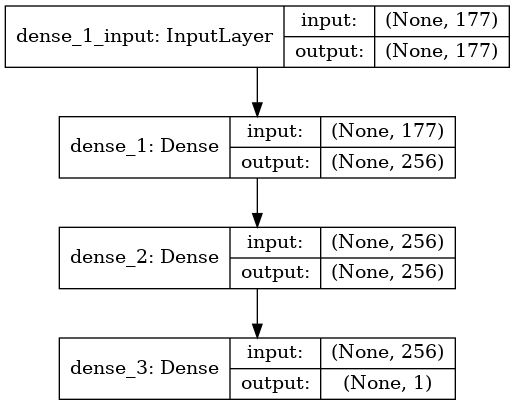

In [64]:
plot_model(model, to_file='model.png',show_shapes=True)

In [65]:
model = Sequential()
model.add(Dense(512,input_dim = x_train.shape[1],activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(x_train,y_train, validation_data = (x_val,y_val),epochs=3, batch_size=64)

Train on 1582048 samples, validate on 175784 samples
Epoch 1/3
1582048/1582048 [==============================] - 483s 305us/step - loss: 64.3142 - accuracy: 0.5555 - val_loss: 0.6866 - val_accuracy: 0.5573
Epoch 2/3
1582048/1582048 [==============================] - 475s 300us/step - loss: 1.0137 - accuracy: 0.5561 - val_loss: 0.6867 - val_accuracy: 0.5573
Epoch 3/3
1582048/1582048 [==============================] - 466s 295us/step - loss: 0.6869 - accuracy: 0.5561 - val_loss: 0.6869 - val_accuracy: 0.5573


In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train) # solo con x_train porque y_train ya esta estandarizada (outcome)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)


print(x_train.shape)
print(y_train.shape)

(1582048, 177)
(1582048,)


In [67]:
#Red neuronal de 2 capas
model = Sequential()
model.add(Dense(512,input_dim = x_train_scaled.shape[1],activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(x_train_scaled,y_train, validation_data = (x_val_scaled,y_val),epochs=3, batch_size=64)

Train on 1582048 samples, validate on 175784 samples
Epoch 1/3
1582048/1582048 [==============================] - 430s 272us/step - loss: 0.1974 - accuracy: 0.9129 - val_loss: 0.1430 - val_accuracy: 0.9405
Epoch 2/3
1582048/1582048 [==============================] - 420s 265us/step - loss: 0.1183 - accuracy: 0.9519 - val_loss: 0.1057 - val_accuracy: 0.9575
Epoch 3/3
1582048/1582048 [==============================] - 424s 268us/step - loss: 0.0912 - accuracy: 0.9641 - val_loss: 0.0915 - val_accuracy: 0.9643


In [68]:
model = Sequential()
model.add(Dense(512,input_dim = x_train_scaled.shape[1],activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])
history = model.fit(x_train_scaled,y_train, validation_data = (x_val_scaled,y_val),epochs=12, batch_size=64)

Train on 1582048 samples, validate on 175784 samples
Epoch 1/12
1582048/1582048 [==============================] - 463s 293us/step - loss: 0.1980 - accuracy: 0.9124 - val_loss: 0.1438 - val_accuracy: 0.9397
Epoch 2/12
1582048/1582048 [==============================] - 454s 287us/step - loss: 0.1179 - accuracy: 0.9523 - val_loss: 0.1043 - val_accuracy: 0.9588
Epoch 3/12
1582048/1582048 [==============================] - 466s 294us/step - loss: 0.0907 - accuracy: 0.9642 - val_loss: 0.0912 - val_accuracy: 0.9659
Epoch 4/12
1582048/1582048 [==============================] - 461s 291us/step - loss: 0.0764 - accuracy: 0.9706 - val_loss: 0.0808 - val_accuracy: 0.9702
Epoch 5/12
1582048/1582048 [==============================] - 457s 289us/step - loss: 0.0668 - accuracy: 0.9744 - val_loss: 0.0776 - val_accuracy: 0.9719
Epoch 6/12
1582048/1582048 [==============================] - 457s 289us/step - loss: 0.0604 - accuracy: 0.9769 - val_loss: 0.0723 - val_accuracy: 0.9754
Epoch 7/12
1582048/1582

In [69]:
result = model.evaluate(x_test_scaled,y_test)
for i in range(len(model.metrics_names)):
 print("Metric ",model.metrics_names[i],":",
str(round(result[i],2)))

439459/439459 [==============================] - 74s 167us/step
Metric  loss : 0.06
Metric  accuracy : 0.98


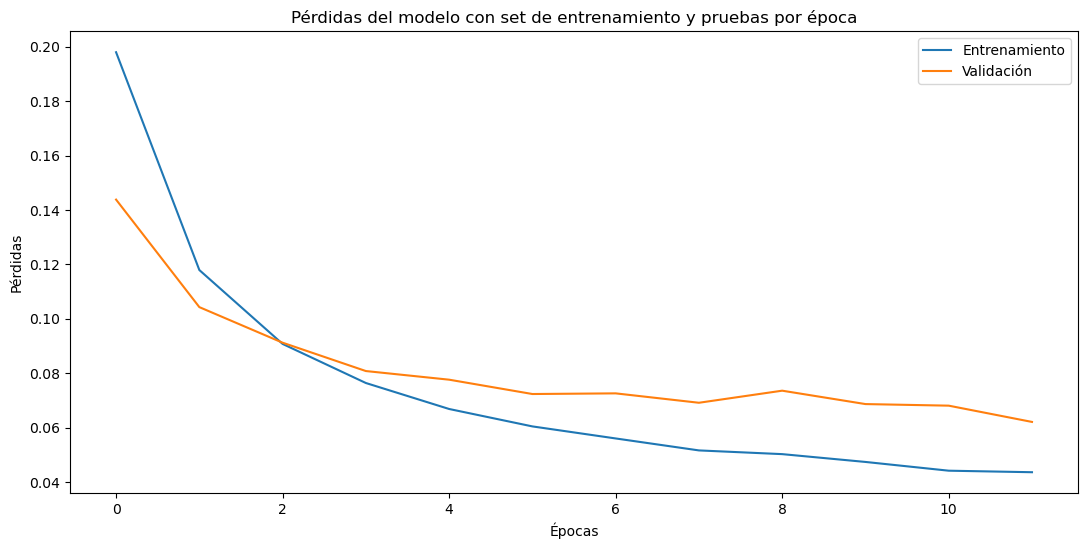

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(13,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Pérdidas del modelo con set de entrenamiento y pruebas por época")
plt.ylabel('Pérdidas')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

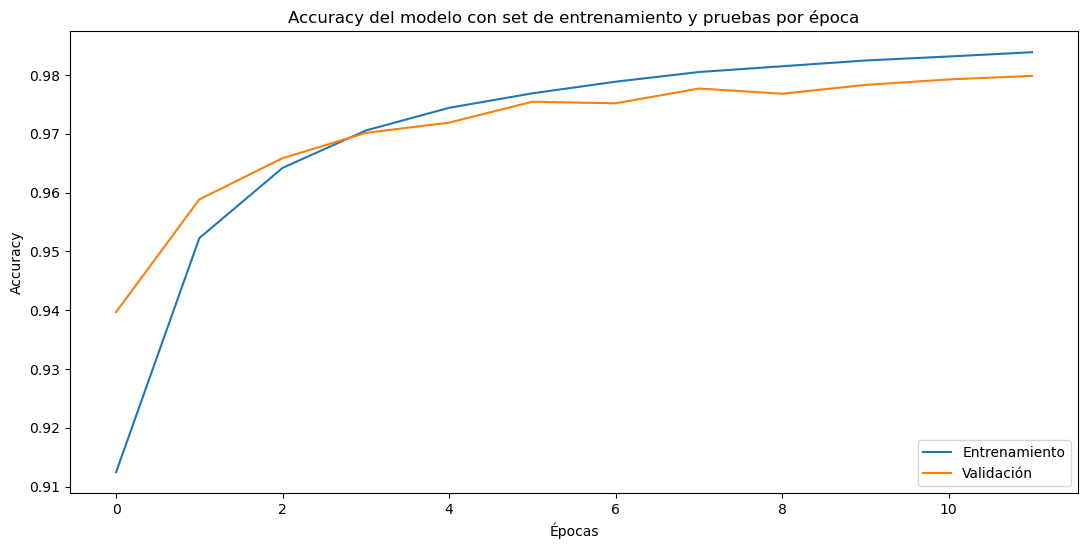

In [71]:
plt.figure(figsize=(13,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy del modelo con set de entrenamiento y pruebas por época")
plt.ylabel('Accuracy')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
plt.show()